# Trabajo Práctico Integrador 1

## Análisis de datos

#### Integrantes
- Daniel Bazan
- Santiago Casado

## 1. Dataset seleccionado

### **Conflictos armados en ciudades (Cities and Armed Conflict Events, CACE)**

El dataset CACE (Conflictos Armados y Eventos de Violencia) es una base de datos global que registra conflictos armados, violencia organizada y eventos bélicos a nivel mundial entre 1989 y 2017.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### a. Descargar el dataset a través de la página oficial

Observando el archivo, se tuvo que agregar el delimitador ";" para poder importarlo correctamente.

In [63]:
path = "dataset/CACE_1989-2017.csv"

# df = pd.read_csv(path, delimiter=';', low_memory=False)
df = pd.read_csv(path, delimiter=';')

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_2408/2020675959.py:4: DtypeWarning: Columns (8,15,17,18,19,20,43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter=';')


## 2. Preprocesamiento de los datos

#### a. Columnas y tipos de datos

In [64]:
df.columns

Index(['id', 'active_year', 'type_of_violence', 'conflict_new_id',
       'conflict_name', 'dyad_new_id', 'dyad_name', 'side_a_new_id', 'gwnoa',
       'side_a', 'side_b_new_id', 'gwnob', 'side_b', 'where_prec',
       'where_coordinates', 'City', 'CACE cityname', 'Capital', 'Majorcity',
       'Top3cities', 'Comment', 'adm_1', 'adm_2', 'latitude', 'longitude',
       'geom_wkt', 'priogrid_gid', 'country', 'country_id', 'region',
       'event_clarity', 'date_prec', 'year', 'date_start', 'date_end',
       'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best',
       'low', 'high', 'Unnamed: 42', 'Unnamed: 43'],
      dtype='object')

#### b. Detalles de las columnas del dataset

**Fecha**
| Columna       | Descripción                                                |
| ------------- | ---------------------------------------------------------- |
| `active_year` | Estado del conflicto en ese año (1 = activo, 0 = no activo) |
| `year`        | Año del evento |
| `date_start`  | Fecha de inicio del evento |
| `date_end`    | Fecha de fin del evento |
| `date_prec`   | Precisión de la fecha (1 = exacta, 5 = mas de un mes, menos de un año)|

**Ubicacion**
| Columna             | Descripción                                                          |
| ------------------- | -------------------------------------------------------------------- |
| `where_prec` | Indica la precisión de la ubicación del evento:<br>1 = Precisión exacta<br>2 = Radio de 25 km<br>3 = Municipio/distrito<br>4 = Provincia/estado<br>5 = Sin límites claros<br>6 = Solo país<br>7 = Agua/espacio |
| `where_coordinates` | Nombre del lugar del evento |
| `adm_1`             | División administrativa de primer nivel (estado, provincia, etc) |
| `adm_2`             | División administrativa de segundo nivel (municipio, distrito, etc)|
| `latitude`          | Latitud del evento |
| `longitude`         | Longitud del evento |
| `geom_wkt`          | Representación geográfica en formato WKT|
| `priogrid_gid`      | ID de celda espacial de 0.5° x 0.5° (Priogrid)|
| `country`           | Nombre del país |
| `country_id`        | Código del país según Gleditsch & Ward |
| `region`            | Región geográfica amplia (America, Asia, etc.)|
| `City`              | 1 = ocurrió en ciudad (>100.000 hab.), 0 = no |
| `CACE cityname`     | Nombre de la ciudad si es evento urbano según ONU |
| `Capital`           | 1 = ocurrió en capital nacional |
| `Majorcity`         | 1 = ocurrió en ciudad de más de 750.000 habitantes |
| `Top3cities`        | Indica si ocurrió en una de las tres ciudades más grandes del país|

**Entidades participantes**
| Columna            | Descripción                                                     |
| ------------------ | --------------------------------------------------------------- |
| `type_of_violence` | Tipo de violencia: 1 = estatal, 2 = no estatal, 3 = unilateral  |
| `conflict_new_id`  | ID conflicto |
| `conflict_name`    | Nombre del conflicto |
| `dyad_new_id`      | ID de la díada (relación entre dos actores)|
| `dyad_name`        | Par de actores que interactúan entre sí|
| `side_a_new_id`    | ID del actor A |
| `gwnoa`            | Código de país del actor A|
| `side_a`           | Nombre del actor que inicia el evento|
| `side_b_new_id`    | ID del actor B|
| `gwnob`            | Código de país del actor B|
| `side_b`           | Nombre del actor que es atacado (puede ser vacío)|

**Víctimas**
| Columna            | Descripción                                          |
| ------------------ | ---------------------------------------------------- |
| `deaths_a`         | Muertes en el actor A |
| `deaths_b`         | Muertes en el actor B |
| `deaths_civilians` | Muertes de civiles |
| `deaths_unknown`   | Muertes no clasificadas |
| `best`             | Estimación central de muertes totales |
| `low`              | Estimación mínima |
| `high`             | Estimación máxima |

**Datos prescindibles**
| Columna         | Descripción                                                            |
| --------------- | ---------------------------------------------------------------------- |
| `id`            | ID general del evento |
| `event_clarity` | Grado de certeza del evento (1 = claro, 2 = bajo) |
| `Comment`       | Comentarios |
| `Unnamed: 42`   | Columna sin nombre |
| `Unnamed: 43`   | Columna sin nombre |


#### c. Eliminación de columnas

Se eliminan las columnas con información redundante o que no aporten valor para un modelo de machine learning.

In [65]:
columnasPrescindibles = [
    'id',                     
    'conflict_name',          # Redundante con side_a, side_b y dyad
    'side_a_new_id',          
    'side_b_new_id',
    'gwnoa',                  # Redundante con country
    'gwnob',
    'country_id',             
    'geom_wkt',               # Para la ubicación se utilizará la longitud y latitud
    'where_coordinates',      # Texto libre, no aporta valor
    'Comment',                # Texto libre, no aporta valor
    'Unnamed: 42',            # Columnas vacías
    'Unnamed: 43',
    'event_clarity',          # Precisión de claridad de evento, no ayuda a la predicción
    'date_prec',              # Precisión de fecha, no ayuda a la predicción
    'where_prec',             # Precisión de ubicación, no ayuda a la predicción
    'conflict_new_id',        
    'dyad_new_id',            
    'priogrid_gid'            # Para la ubicación se utilizará la longitud y latitud
]

df_cace = df.drop(columns=columnasPrescindibles, axis = 1)

#### d. Datos faltantes o duplicados

In [66]:
print(f"Valores faltantes: {df_cace.isna().sum()}")  # Calcular valores faltantes

Valores faltantes: active_year              0
type_of_violence         0
dyad_name                0
side_a                   0
side_b                   0
City                     0
CACE cityname       117996
Capital                  0
Majorcity                0
Top3cities               0
adm_1                 7237
adm_2                37225
latitude                 0
longitude                0
country                  0
region                   0
year                     0
date_start               0
date_end                 0
deaths_a                 0
deaths_b                 0
deaths_civilians         0
deaths_unknown           0
best                     0
low                      0
high                     0
dtype: int64


In [67]:
# Calcular la proporción de valores nulos en cada columna
df_cace.isna().mean().round(2)*100

active_year          0.0
type_of_violence     0.0
dyad_name            0.0
side_a               0.0
side_b               0.0
City                 0.0
CACE cityname       83.0
Capital              0.0
Majorcity            0.0
Top3cities           0.0
adm_1                5.0
adm_2               26.0
latitude             0.0
longitude            0.0
country              0.0
region               0.0
year                 0.0
date_start           0.0
date_end             0.0
deaths_a             0.0
deaths_b             0.0
deaths_civilians     0.0
deaths_unknown       0.0
best                 0.0
low                  0.0
high                 0.0
dtype: float64

In [68]:
print("Cantidad de datos duplicados:", df_cace.duplicated().sum())

Cantidad de datos duplicados: 1389


Se eliminan los datos duplicados:

In [69]:
df_cace = df_cace.drop_duplicates()

print("Cantidad de datos duplicados:", df_cace.duplicated().sum())

Cantidad de datos duplicados: 0


Finalmente, el dataset tiene la siguiente dimensión:

In [70]:
df_cace.shape

(141513, 26)

#### e. Correción de tipo de datos

Se identifican las columnas con distintos tipo de datos y se unifica:

In [71]:
columnasMuchosTipos = []

i = 0
for col in df_cace.columns:
    unique_types = df_cace[col].apply(type).unique()
    if len(unique_types) > 1:
        columnasMuchosTipos.append(col)
        print(f"\n Columna {i}: {col}")
        print("Tipos encontrados:", unique_types)
        
        #Se muestran 2 ejemplos para cada columna con mas de un tipo de dato
        for dtype in unique_types:
            examples = df_cace[df_cace[col].apply(lambda x: type(x) == dtype)][col].head(2).tolist()
            print(f"  - Tipo {dtype}: {examples}")

    i += 1


 Columna 5: City
Tipos encontrados: [<class 'int'> <class 'str'>]
  - Tipo <class 'int'>: [1, 1]
  - Tipo <class 'str'>: ['0', '0']

 Columna 6: CACE cityname
Tipos encontrados: [<class 'str'> <class 'float'>]
  - Tipo <class 'str'>: ['Şan‘ā’', '‘Adan ']
  - Tipo <class 'float'>: [nan, nan]

 Columna 7: Capital
Tipos encontrados: [<class 'int'> <class 'str'>]
  - Tipo <class 'int'>: [1, 0]
  - Tipo <class 'str'>: ['0', '0']

 Columna 8: Majorcity
Tipos encontrados: [<class 'int'> <class 'str'>]
  - Tipo <class 'int'>: [1, 0]
  - Tipo <class 'str'>: ['0', '0']

 Columna 9: Top3cities
Tipos encontrados: [<class 'int'> <class 'str'>]
  - Tipo <class 'int'>: [1, 0]
  - Tipo <class 'str'>: ['0', '0']

 Columna 10: adm_1
Tipos encontrados: [<class 'str'> <class 'float'>]
  - Tipo <class 'str'>: ['Am?nat al ‘??imah governorate', '‘Adan governorate']
  - Tipo <class 'float'>: [nan, nan]

 Columna 11: adm_2
Tipos encontrados: [<class 'float'> <class 'str'>]
  - Tipo <class 'float'>: [nan, nan]

In [ ]:
import datetime

# Columnas binarias
binary_cols = ['City', 'Capital', 'Majorcity', 'Top3cities']

for col in binary_cols:
    # Reemplazar valores conocidos
    df_cace[col] = df_cace[col].replace({
        '0': 0, '1': 1,
        0: 0, 1: 1,
        'True': 1, 'False': 0,
        True: 1, False: 0
    })
    
    # Convertir otros valores a NaN
    df_cace[col] = pd.to_numeric(df_cace[col], errors='coerce')
    
    # Rellenar NaN con 0 o 1 según sea apropiado
    df_cace[col] = df_cace[col].fillna(0).astype('int8')

# Columnas de fechas
date_cols = ['date_start', 'date_end']
for col in date_cols:
    df_cace[col] = pd.to_datetime(df_cace[col])

print("\nTipos unificados:")
print(df_cace.dtypes)


Tipos unificados:
active_year                  int64
type_of_violence             int64
dyad_name                   object
side_a                      object
side_b                      object
City                          int8
CACE cityname               object
Capital                       int8
Majorcity                     int8
Top3cities                    int8
adm_1                       object
adm_2                       object
latitude                   float64
longitude                  float64
country                     object
region                      object
year                         int64
date_start          datetime64[ns]
date_end            datetime64[ns]
deaths_a                     int64
deaths_b                     int64
deaths_civilians             int64
deaths_unknown               int64
best                         int64
low                          int64
high                         int64
dtype: object


#### f. Información general de dataset

In [73]:
df_cace.head()

,active_year,type_of_violence,dyad_name,side_a,side_b,City,CACE cityname,Capital,Majorcity,Top3cities,...,year,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high
0,1,1,Government of Yemen (North Yemen) - AQAP,Government of Yemen (North Yemen),AQAP,1,Şan‘ā’,1,1,1,...,2010,2010-09-25,2010-09-25,2,0,0,0,2,2,2
1,1,3,Government of Yemen (North Yemen) - Civilians,Government of Yemen (North Yemen),Civilians,1,‘Adan,0,0,0,...,2011,2011-02-19,2011-02-19,0,0,0,0,0,0,2
2,1,1,Government of Yemen (North Yemen) - AQAP,Government of Yemen (North Yemen),AQAP,0,NaN,0,0,0,...,2011,2011-04-16,2011-04-16,0,0,0,0,0,0,1
3,1,1,Government of Yemen (North Yemen) - AQAP,Government of Yemen (North Yemen),AQAP,0,NaN,0,0,0,...,2012,2012-06-04,2012-06-04,4,1,0,0,5,5,5
4,1,1,Government of Yemen (North Yemen) - AQAP,Government of Yemen (North Yemen),AQAP,0,NaN,0,0,0,...,2012,2012-12-09,2012-12-09,0,4,1,0,5,5,5


In [74]:
df_cace.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141513 entries, 0 to 142901
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   active_year       141513 non-null  int64         
 1   type_of_violence  141513 non-null  int64         
 2   dyad_name         141513 non-null  object        
 3   side_a            141513 non-null  object        
 4   side_b            141513 non-null  object        
 5   City              141513 non-null  int8          
 6   CACE cityname     24480 non-null   object        
 7   Capital           141513 non-null  int8          
 8   Majorcity         141513 non-null  int8          
 9   Top3cities        141513 non-null  int8          
 10  adm_1             134358 non-null  object        
 11  adm_2             104778 non-null  object        
 12  latitude          141513 non-null  float64       
 13  longitude         141513 non-null  float64       
 14  country  

#### g. Consistencia de datos

In [75]:
# Se verifica si existen valores negativos en features que deberían tener enteros no negativos.
columnasVictimas = ['deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best', 'low', 'high']
negativos = df_cace[columnasVictimas] < 0
print("Valores negativos por columna:")
print(negativos.sum())

# Verificar fechas: inicio <= fin
fechas_invalidas = df_cace['date_start'] > df_cace['date_end']
print('')
print(f"Eventos con fecha de inicio posterior a la fecha de fin: {fechas_invalidas.sum()}")

# Verificar coordenadas válidas
coordenadasInvalidas = ((df_cace['latitude'] < -90) | (df_cace['latitude'] > 90) |
                         (df_cace['longitude'] < -180) | (df_cace['longitude'] > 180))
print('')
print(f"Coordenadas inválidas: {coordenadasInvalidas.sum()}")

Valores negativos por columna:
deaths_a            0
deaths_b            0
deaths_civilians    0
deaths_unknown      0
best                0
low                 0
high                0
dtype: int64

Eventos con fecha de inicio posterior a la fecha de fin: 0

Coordenadas inválidas: 0


#### h. Ajuste de los tipos de datos

In [76]:
# Categorías nominales
nominales = ['dyad_name', 'side_a', 'side_b', 'CACE cityname', 'adm_1', 'adm_2', 'country', 'region', 'type_of_violence']
df_cace[nominales] = df_cace[nominales].astype('category')

# Categorías ordinales
ordinales = ['City', 'Capital', 'Majorcity', 'Top3cities', 'active_year']
df_cace[ordinales] = df_cace[ordinales].astype('category')

df_cace.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141513 entries, 0 to 142901
Data columns (total 26 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   active_year       141513 non-null  category      
 1   type_of_violence  141513 non-null  category      
 2   dyad_name         141513 non-null  category      
 3   side_a            141513 non-null  category      
 4   side_b            141513 non-null  category      
 5   City              141513 non-null  category      
 6   CACE cityname     24480 non-null   category      
 7   Capital           141513 non-null  category      
 8   Majorcity         141513 non-null  category      
 9   Top3cities        141513 non-null  category      
 10  adm_1             134358 non-null  category      
 11  adm_2             104778 non-null  category      
 12  latitude          141513 non-null  float64       
 13  longitude         141513 non-null  float64       
 14  country  

## 3. Análisis exploratorio de datos

### Variables categóricas

#### a. Caracteristicas generales


In [77]:
df_cace.describe(include='category')

,active_year,type_of_violence,dyad_name,side_a,side_b,City,CACE cityname,Capital,Majorcity,Top3cities,adm_1,adm_2,country,region
count,141513,141513,141513,141513,141513,141513,24480,141513,141513,141513,134358,104778,141513,141513
unique,2,3,1239,696,710,2,980,2,2,2,1415,6424,118,5
top,1,1,Government of Afghanistan - Taleban,Government of Afghanistan,Civilians,0,Mogadishu,0,0,0,Jammu and Kashmir State,Mogadishu district,Afghanistan,Asia
freq,134389,100004,21237,23807,29302,117033,1767,134420,132823,130237,7626,1790,25116,67505


En la descripción general, se pueden destacar los siguientes puntos:

- De las entidades participantes, las que tienen mas eventos son:
  - El gobierno de Afganistan (puede deberse a conflictos bélicos)
  - Civiles (atentados o daños colaterales)
- El conflicto (diada o par de entidades) que tiene mas eventos es entre el gobierno de Afganistán y los talibanes.
- En base a lo anterior, es lógico que el país y continente con mas eventos sea Afganistan y Asia.


#### b. Entidades participantes

In [78]:
# Primeras 10 entidades que inician el evento (o atacan) que mas se repiten
df_cace['side_a'].value_counts().head(10)

side_a
Government of Afghanistan              23807
Government of India                    10257
Government of Iraq                      5414
Government of Turkey                    4538
Government of Nepal                     4490
Government of Sri Lanka                 4167
Government of Pakistan                  4031
Government of Algeria                   3778
Government of Russia (Soviet Union)     3561
Government of Colombia                  3466
Name: count, dtype: int64

In [79]:
# Primeras 10 entidades que son atacadas que mas se repiten
df_cace['side_b'].value_counts().head(10)

side_b
Civilians             29302
Taleban               21372
IS                     6470
Kashmir insurgents     5837
PKK                    4469
LTTE                   4001
CPN-M                  3669
TTP                    3553
FARC                   2864
Al-Shabaab             2817
Name: count, dtype: int64

#### c. Conflictos mas comunes

In [80]:
# Primeros 10 par de actores enfretados en un evento
df_cace['dyad_name'].value_counts().head(10)

dyad_name
Government of Afghanistan - Taleban         21237
Government of India - Kashmir insurgents     5837
Government of Iraq - IS                      4621
Government of Turkey - PKK                   4434
Government of Sri Lanka - LTTE               3993
Government of Nepal - CPN-M                  3669
Government of Pakistan - TTP                 3489
Government of Colombia - FARC                2729
Government of Somalia - Al-Shabaab           2678
Government of Algeria - AQIM                 1816
Name: count, dtype: int64

In [81]:
# Se obtienen el top 10 para hacer mas legible el gráfico
topAtacantes = df_cace['side_a'].value_counts().head(10).index
topVictimas = df_cace['side_b'].value_counts().head(10).index

paresFiltrados = df_cace[df_cace['side_a'].isin(topAtacantes) & df_cace['side_b'].isin(topVictimas)]

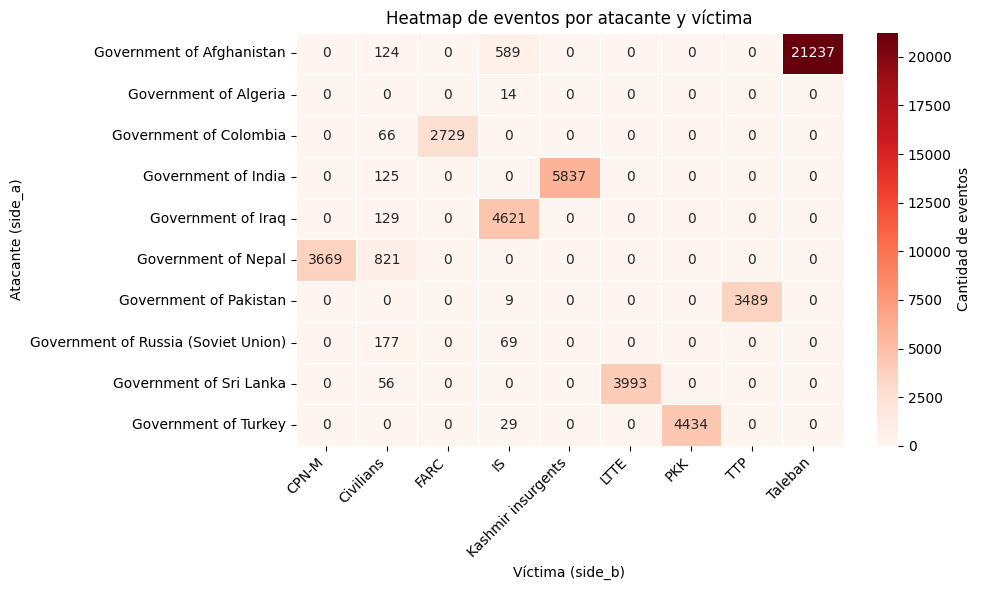

In [82]:
# Se crea la tabla de frecuencia cruzada (matriz atacante - víctima)
tabla = pd.crosstab(paresFiltrados['side_a'], paresFiltrados['side_b'])

# Visualizar como heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(tabla, annot=True, fmt='d', cmap='Reds', linewidths=0.5, cbar_kws={'label': 'Cantidad de eventos'})

plt.title('Heatmap de eventos por atacante y víctima')
plt.xlabel('Víctima (side_b)')
plt.ylabel('Atacante (side_a)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### d. Represalias

Se generan dos heatmap:
- Las 10 entidades que atacan, que tambien son atacadas
- Las 10 entidades que son atacadas, que también atacaron

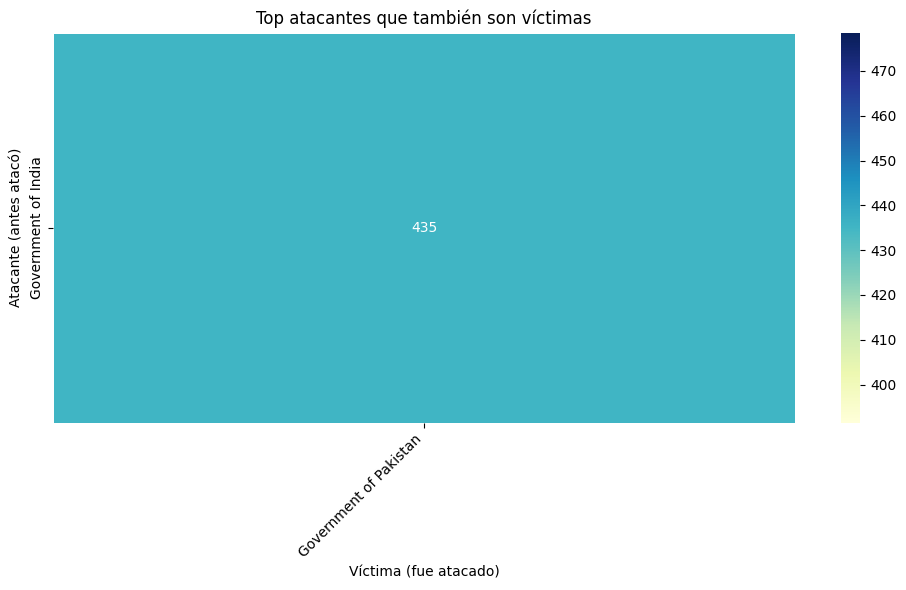

In [83]:
atacantesVictimas = topAtacantes.intersection(df_cace['side_b'])

df_atacantesVictimas = df_cace[df_cace['side_b'].isin(atacantesVictimas) & df_cace['side_a'].isin(topAtacantes)]

# Matriz de eventos donde los top atacantes también son atacados
heatmap_atacantesVictimas = pd.crosstab(df_atacantesVictimas['side_a'], df_atacantesVictimas['side_b'])

# Graficar
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_atacantesVictimas, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5)
plt.title("Top atacantes que también son víctimas")
plt.xlabel("Víctima (fue atacado)")
plt.ylabel("Atacante (antes atacó)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Como son eventos de conflictos armados entre dos entidades gubernamentales, se puede considerar un conflicto bélico entre los paises.

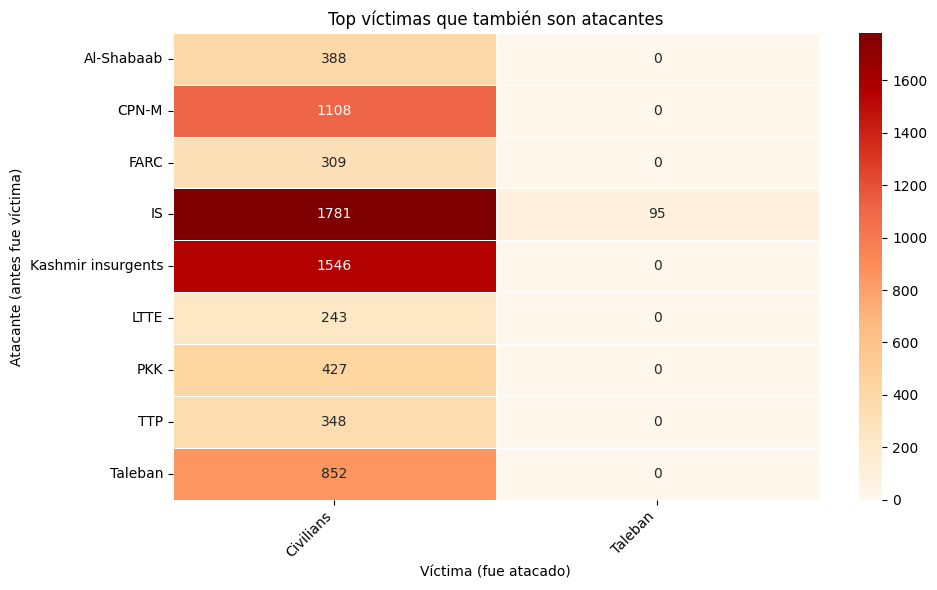

In [84]:
victimasAtacantes = topVictimas.intersection(df_cace['side_a'])

# Filtrar eventos donde esas víctimas luego atacan
df_victimasAtacantes = df_cace[df_cace['side_a'].isin(victimasAtacantes) & df_cace['side_b'].isin(topVictimas)]

# Matriz de eventos donde las top víctimas también son atacantes
heatmap_va = pd.crosstab(df_victimasAtacantes['side_a'], df_victimasAtacantes['side_b'])

# Graficar
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_va, annot=True, fmt='d', cmap='OrRd', linewidths=0.5)
plt.title("Top víctimas que también son atacantes")
plt.xlabel("Víctima (fue atacado)")
plt.ylabel("Atacante (antes fue víctima)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

En este caso, las entidades del eje vertical tienen muchos eventos con civiles como victimas. Por lo tanto, se los puede considerar grupos terroristas.

#### e. Geografía de los eventos

**Regiones**

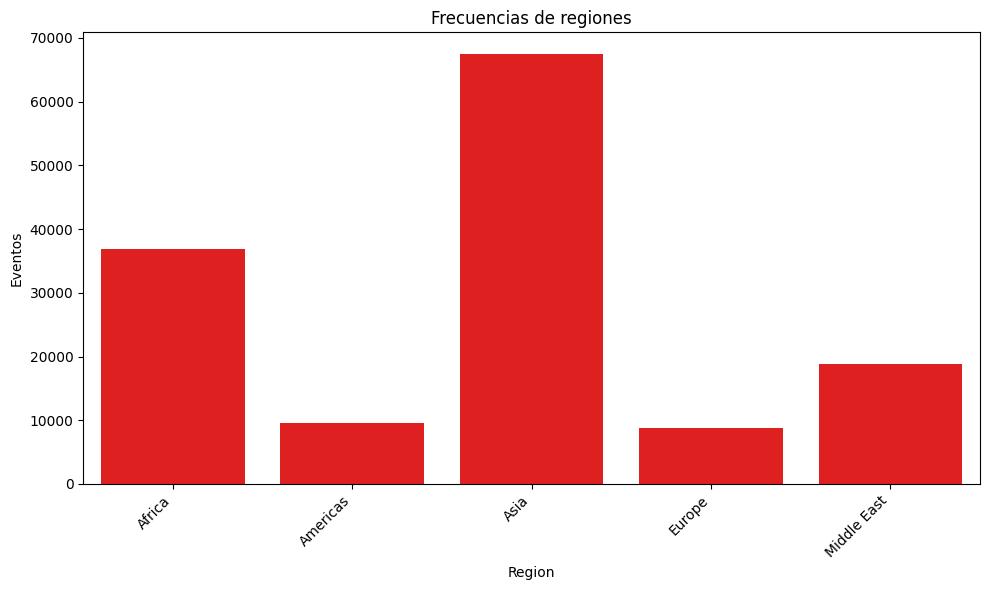

In [85]:
# Graficar
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cace, x='region', color="red")
plt.title("Frecuencias de regiones")
plt.xlabel("Region")
plt.ylabel("Eventos")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

**Top 20 paises**

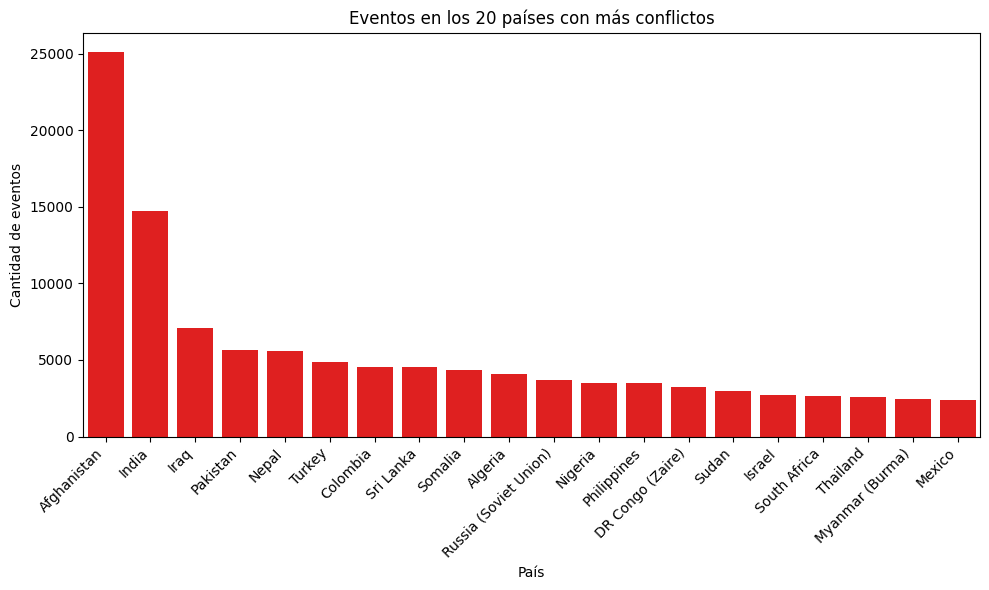

In [86]:
cantidadPaises = 20

topPaises = df_cace['country'].value_counts().head(cantidadPaises).index

# Graficar
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cace, x='country', order = topPaises, color='red')
plt.title(f"Eventos en los {cantidadPaises} países con más conflictos")
plt.ylabel('Cantidad de eventos')
plt.xlabel('País')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Top 20 ciudades**

In [87]:
eventosCiudad = df_cace['City'].value_counts()

print('Eventos que:')
print(f"- Ocurrieron en ciudades: {eventosCiudad.get(1, 0)}")
print(f"- No ocurrieron en ciudades: {eventosCiudad.get(0, 0)}")

Eventos que:
- Ocurrieron en ciudades: 24480
- No ocurrieron en ciudades: 117033


Por lo tanto, el top 1 corresponde a los eventos armados que no ocurrieron en ciudades. No se tiene en cuenta para realizar el grafico:

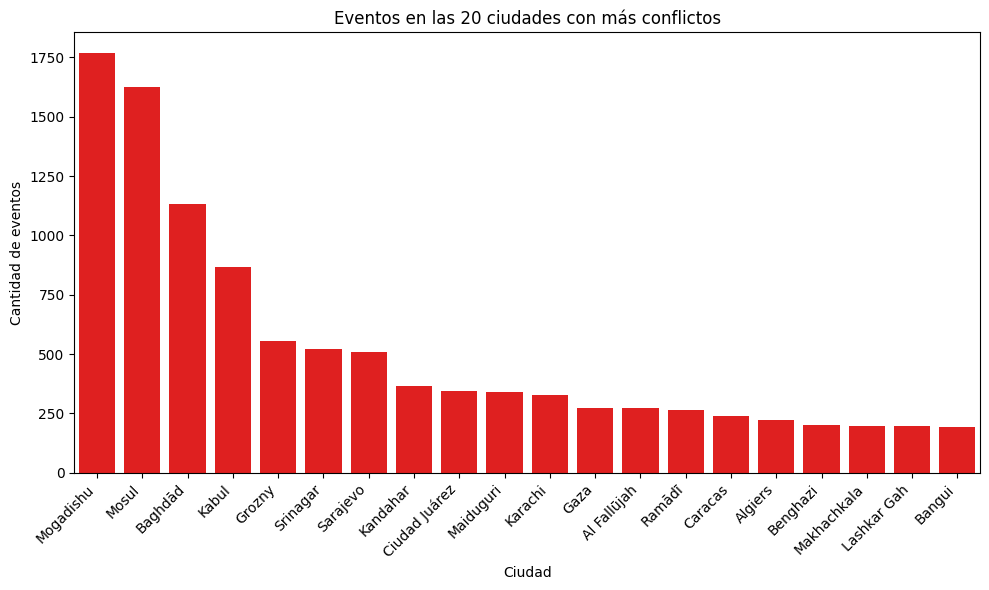

In [88]:
cantidadCiudades = 20

# Se filtran los eventos que ocurrieron en ciudades
df_ciudades = df_cace[df_cace['City'] == 1]

topCiudades = df_ciudades['CACE cityname'].value_counts().head(cantidadCiudades).index

# Graficar
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cace, x='CACE cityname', order = topCiudades, color='red')
plt.title(f"Eventos en las {cantidadCiudades} ciudades con más conflictos")
plt.ylabel('Cantidad de eventos')
plt.xlabel('Ciudad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Variables numéricas

In [89]:
df_cace.describe()

,latitude,longitude,year,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high
count,141513.000000,141513.000000,141513.000000,141513,141513,141513.000000,141513.000000,141513.000000,141513.000000,141513.000000,141513.000000,141513.000000
mean,21.869903,45.689697,2005.411863,2005-11-25 01:08:36.291789568,2005-11-28 23:25:20.485043840,2.185933,3.051741,6.066079,2.953609,14.257362,11.388742,21.034350
min,-34.603333,-117.300000,1989.000000,1989-01-01 00:00:00,1989-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.238208,29.460000,1999.000000,1999-08-15 00:00:00,1999-08-19 00:00:00,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,28.517460,45.990100,2007.000000,2007-01-14 00:00:00,2007-01-16 00:00:00,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,3.000000
75%,34.179444,74.167293,2012.000000,2012-10-20 00:00:00,2012-10-22 00:00:00,1.000000,2.000000,1.000000,0.000000,6.000000,6.000000,7.000000
max,61.250000,155.896681,2017.000000,2017-12-31 00:00:00,2018-01-01 00:00:00,10000.000000,9505.000000,300559.000000,48183.000000,300559.000000,48183.000000,547077.000000
std,16.335016,44.988696,8.078129,NaN,NaN,55.158245,34.374924,815.875524,157.267094,833.850684,216.278149,1480.863944


En la descripción general, se pueden destacar los siguientes puntos:

- La media de muertes de civiles es mayor que las entidades que protagonizan los conflictos

#### a. Muertes

**Dispersión de las muertes estimadas**

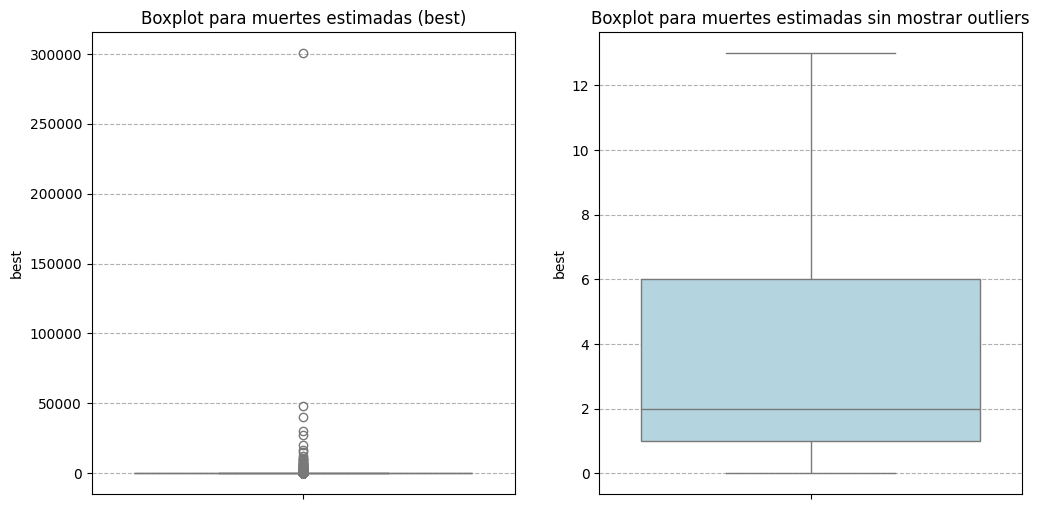

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=df_cace, y='best', color="lightblue", ax=ax[0])
sns.boxplot(data=df_cace, y='best', color="lightblue", showfliers= False, ax=ax[1])       
ax[0].grid(axis='y', ls='--')
ax[0].set_title('Boxplot para muertes estimadas (best)', fontsize=12)
ax[1].grid(axis='y', ls='--')
ax[1].set_title('Boxplot para muertes estimadas sin mostrar outliers', fontsize=12)
plt.show()

Del boxplot se observa que:
- La mediana de muertes es de 2.
- El 50% de las muertes esta entre 2 y 6.
- Los outliers superiores están superando las 13 muertes.
- Hay valores atípicos que superan las 10000 muertes por evento, esto se puede deber a datos mal cargados o genocidios.
- El mínimo, logicamente, es cero muertes.
- La distribución es asimétrica positiva.

#### b. Temporales

**Muertes en el tiempo**

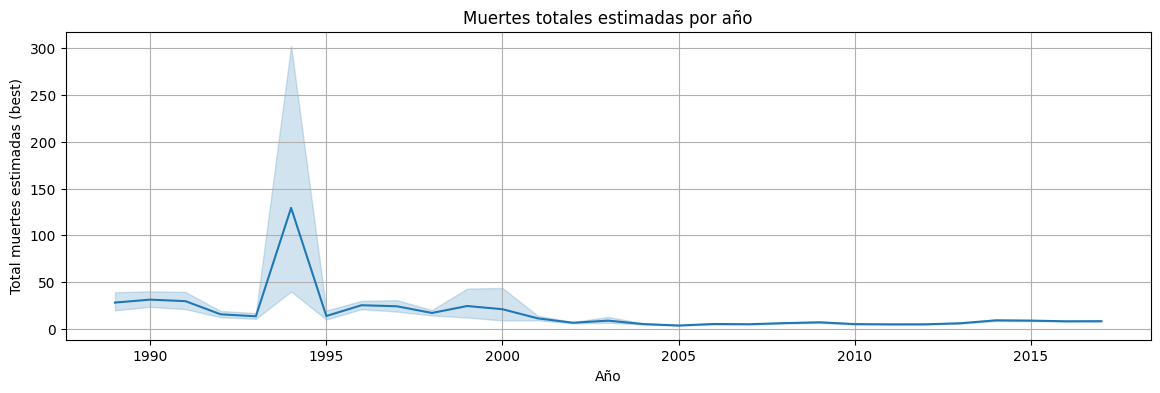

In [91]:
# Turismo receptivo vs emisivo - media mensual
plt.figure(figsize=(14, 4))
sns.lineplot(data=df, x="year", y="best")

# Títulos y etiquetas
plt.title('Muertes totales estimadas por año')
plt.xlabel('Año')
plt.ylabel('Total muertes estimadas (best)')
plt.grid(True)
plt.show()

Observaciones:
- Hay un pico considerable en 1994
- Desviaciones a inicios de los 90 y 2000.

### Visualización entre pares de variables

#### a. Muertes por regiones

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_2408/934313014.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  muertesRegion = df_cace.groupby('region')['best'].sum().sort_values(ascending=False)


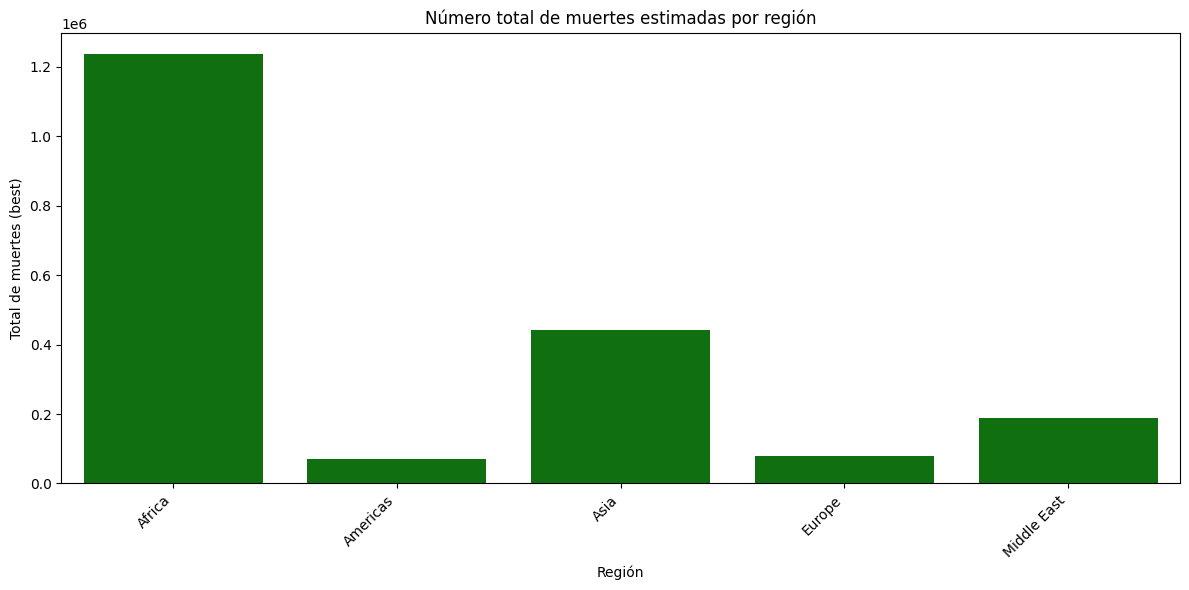

In [92]:
# Agrupar por región y sumar las muertes estimadas
muertesRegion = df_cace.groupby('region')['best'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x = muertesRegion.index, y = muertesRegion.values, color = 'green')

plt.title('Número total de muertes estimadas por región')
plt.xlabel('Región')
plt.ylabel('Total de muertes (best)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Boxplot de muertes estimadas para cada region (sin outliers)**

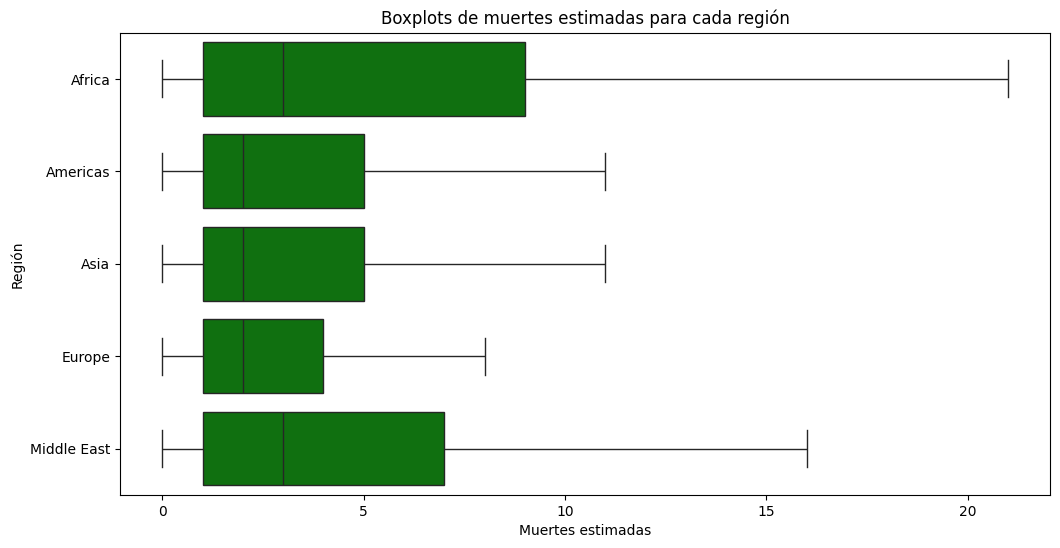

In [93]:
plt.figure(figsize=(12,6))

sns.boxplot(data=df_cace, x='best', y='region', color="green", showfliers=False)
plt.title('Boxplots de muertes estimadas para cada región',fontsize=12)
plt.xlabel('Muertes estimadas')
plt.ylabel('Región')

plt.show()

**Boxplot de muertes estimadas para cada pais**

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_2408/809483495.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topPaises = df_cace.groupby('country')['best'].sum().sort_values(ascending=False).head(20).index.tolist()


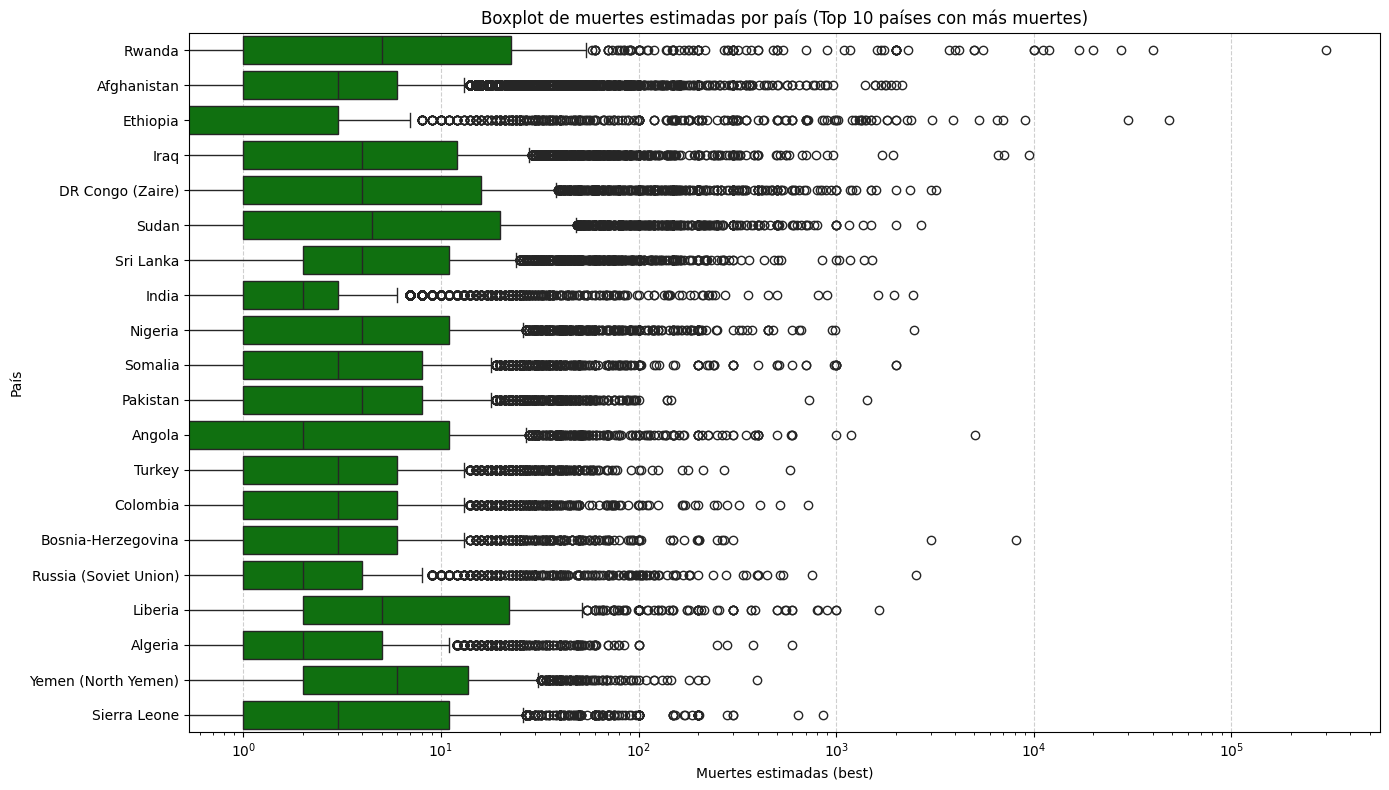

In [94]:
topPaises = df_cace.groupby('country')['best'].sum().sort_values(ascending=False).head(20).index.tolist()

df_topPaises = df_cace[df_cace['country'].isin(topPaises)]

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_topPaises, 
    x='best', 
    y='country', 
    orient='h', 
    color='green',
    order=topPaises
)

plt.title('Boxplot de muertes estimadas por país (Top 10 países con más muertes)')
plt.xlabel('Muertes estimadas (best)')
plt.ylabel('País')
plt.xscale('log')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### b. Paises involucrados en el tiempo

**Cantidad de eventos por pais y año**

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_2408/3257362757.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top20.groupby(['country', 'year'])


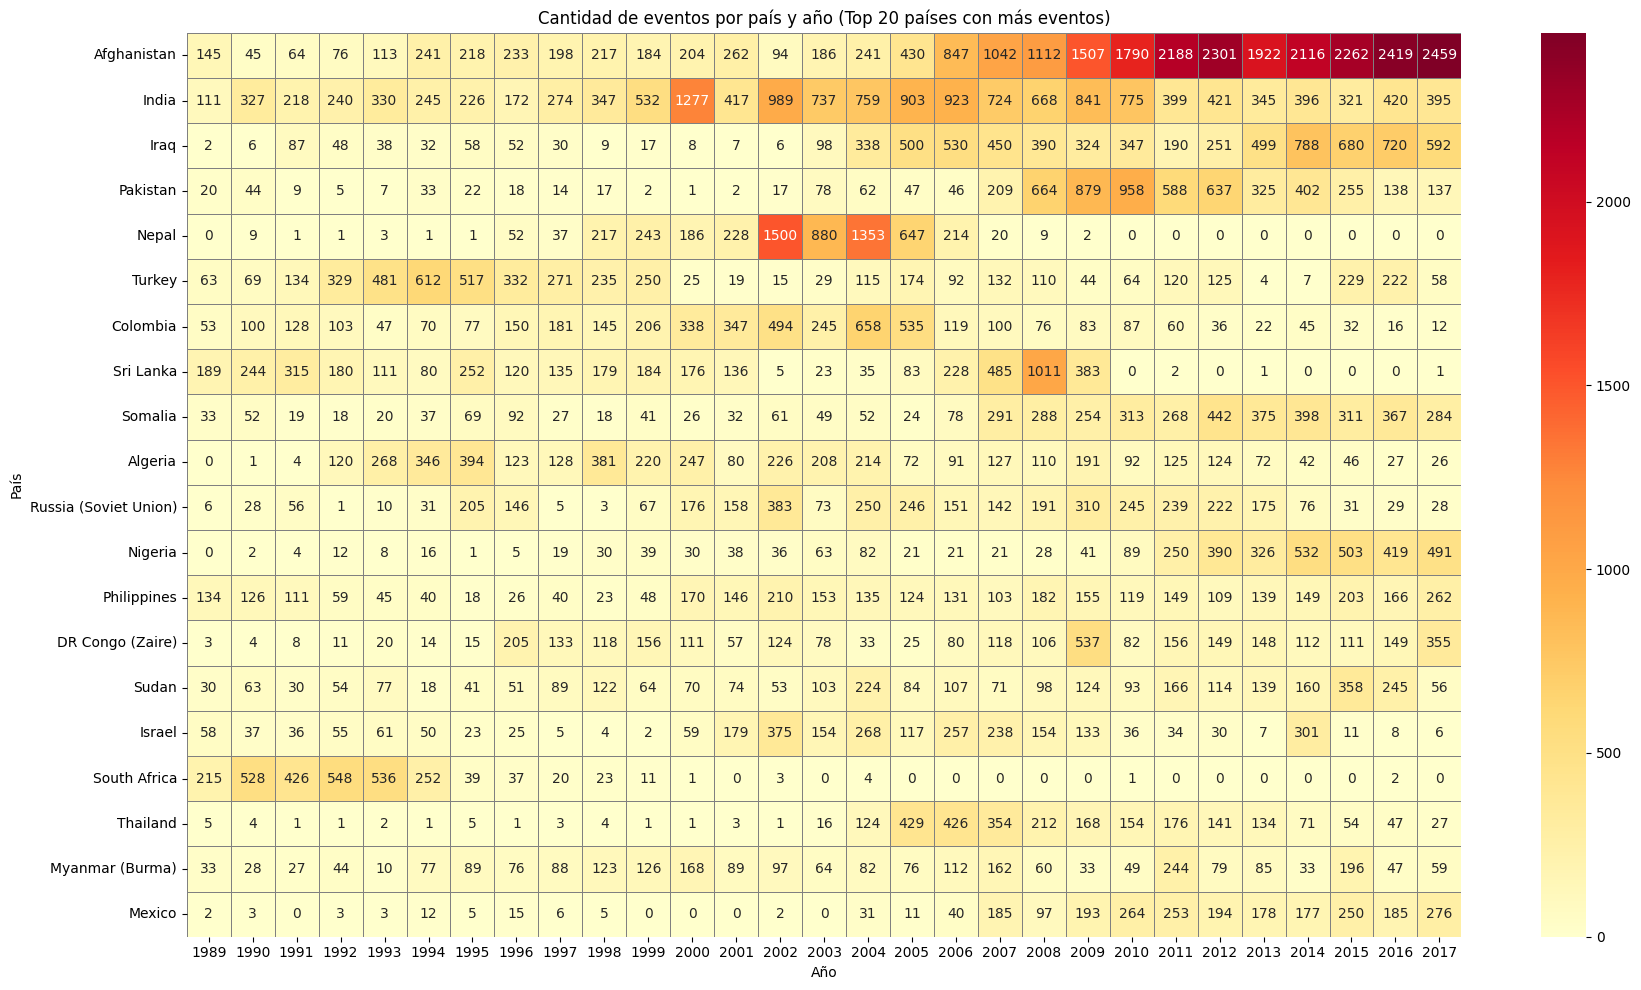

In [95]:
topPaises = df_cace['country'].value_counts().head(20).index.tolist()

df_top20 = df_cace[df_cace['country'].isin(topPaises)].copy()

# Agrupar por país y año (asegurando el orden)
eventos_por_pais_anio = (
    df_top20.groupby(['country', 'year'])
    .size()
    .unstack(fill_value=0)
    .loc[topPaises]
)

# Plot del heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(
    eventos_por_pais_anio,
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor='gray',
    annot=True,  
    fmt='d'
)

plt.title('Cantidad de eventos por país y año (Top 20 países con más eventos)')
plt.xlabel('Año')
plt.ylabel('País')
plt.tight_layout()
plt.show()

**Cantidad de muertes por pais y año**

/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_2408/3041586616.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  topPaisesMuertes = df_cace.groupby('country')['best'].sum().nlargest(20).index.tolist()
/var/folders/_f/7gqqb6190c9b0h_7dkhypsj80000gn/T/ipykernel_2408/3041586616.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_top20_muertes.groupby(['country', 'year'])['best']


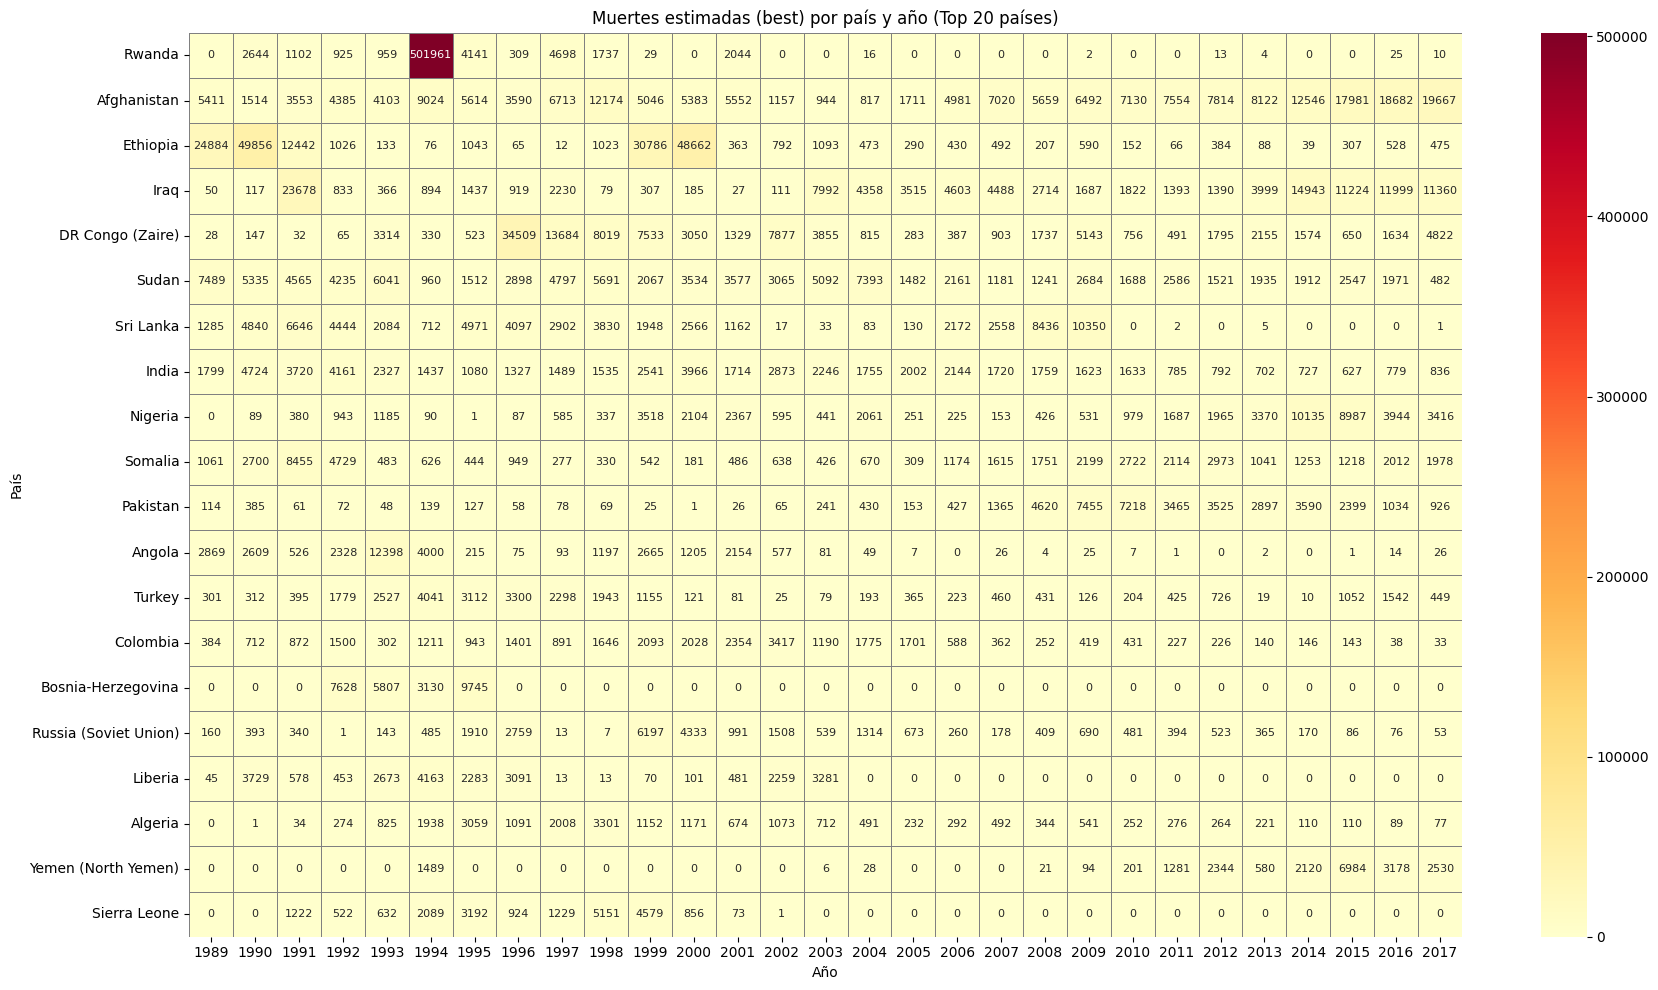

In [96]:
topPaisesMuertes = df_cace.groupby('country')['best'].sum().nlargest(20).index.tolist()

df_top20_muertes = df_cace[df_cace['country'].isin(topPaisesMuertes)].copy()

muertes_por_pais_anio = (
    df_top20_muertes.groupby(['country', 'year'])['best']
    .sum()
    .unstack(fill_value=0)
    .loc[topPaisesMuertes]
)

plt.figure(figsize=(18, 10))
sns.heatmap(
    muertes_por_pais_anio,
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor='gray',
    annot=True,    
    fmt='d',
    annot_kws={'size': 8}
)

plt.title('Muertes estimadas (best) por país y año (Top 20 países)')
plt.xlabel('Año')
plt.ylabel('País')
plt.tight_layout()
plt.show()

Observaciones:
- Se destaca Rwanda en 1994.
- Países como Ethiopia, Sri Lanka, Bosnia-Herzegovina y Sierra Leona tuvieron muchas muertes en la decada del 90 y en adelante, casi sin muertes.
- Afganistán, Iraq, Congo e India son constantes (para mal) en todo el rango de años.

#### c. Distribución geográfica de muertes estimadas por evento

**Considerando todos los eventos**

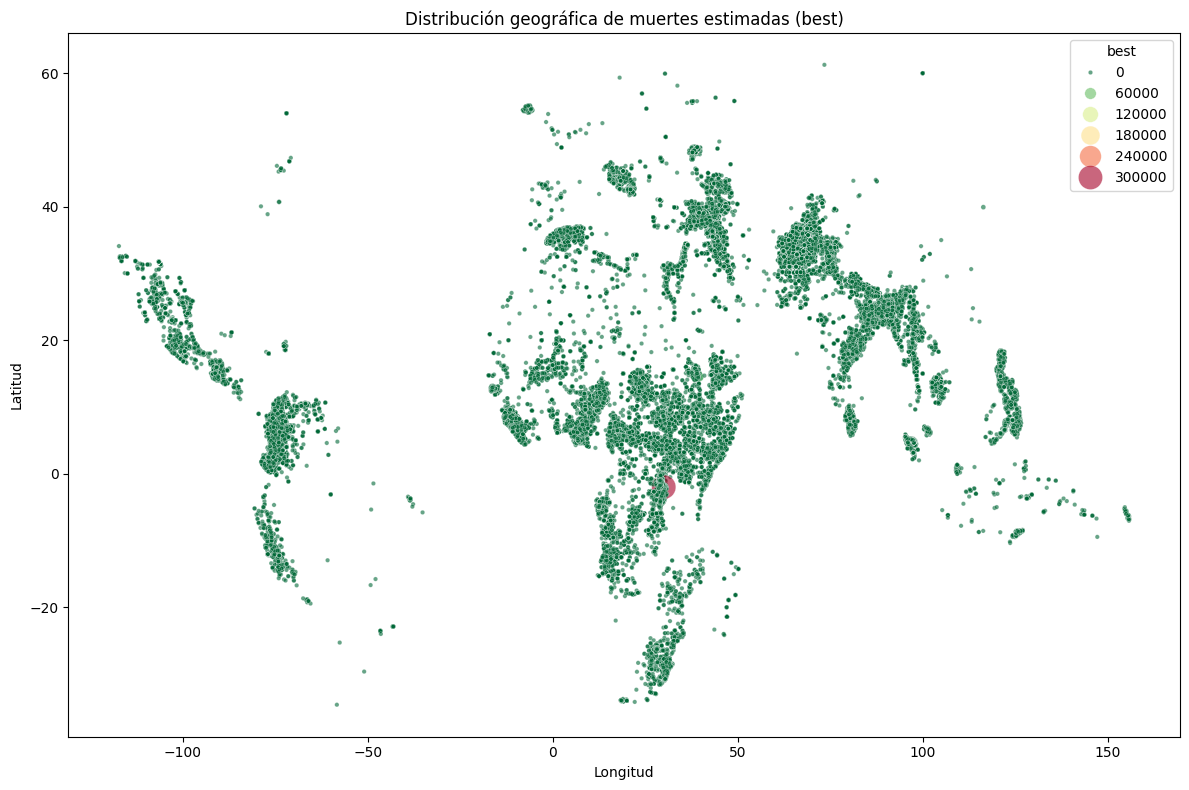

In [97]:
plt.figure(figsize=(12,8))
scatter = sns.scatterplot(
    x='longitude',
    y='latitude',
    hue='best',
    size='best',
    data=df_cace,
    palette='RdYlGn_r',  # verde (0 muertes) a rojo (más muertes)
    sizes=(10, 300),     # 10 (tamaño cero muertes) a 300 (tamaño 300000 muertes)
    alpha=0.6,
    legend='brief'
)

plt.title('Distribución geográfica de muertes estimadas (best)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.tight_layout()
plt.show()

**Conflictos armados en capitales o ciudades con >750000 habitantes**

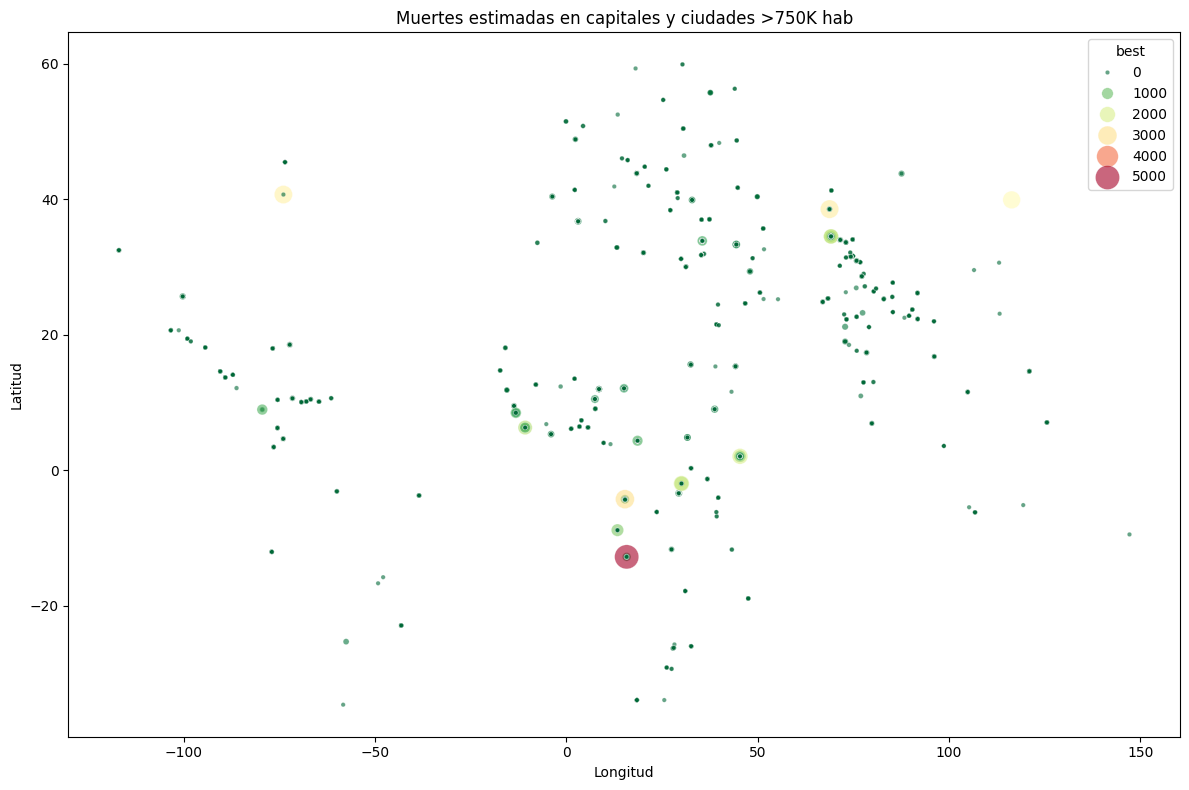

In [98]:
ciudadesGrandes = df_cace[(df_cace['Capital'] == 1) | (df_cace['Majorcity'] == 1)]

plt.figure(figsize=(12,8))
scatter = sns.scatterplot(
    data=ciudadesGrandes,
    x='longitude',
    y='latitude',
    hue='best',
    size='best',
    palette='RdYlGn_r',
    sizes=(10, 300),
    alpha=0.6,
    legend='brief'
)

plt.title('Muertes estimadas en capitales y ciudades >750K hab')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

plt.tight_layout()
plt.show()

### Outliers

**Muertes**

In [99]:
muertesOutliers = df_cace.sort_values(by='best', ascending=False)
muertesOutliers.head(20)

,active_year,type_of_violence,dyad_name,side_a,side_b,City,CACE cityname,Capital,Majorcity,Top3cities,...,year,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best,low,high
28050,1,3,Government of Rwanda - Civilians,Government of Rwanda,Civilians,0,NaN,0,0,0,...,1994,1994-04-06,1994-07-04,0,0,300559,0,300559,0,547077
21194,1,1,Government of Eritrea - Government of Ethiopia,Government of Eritrea,Government of Ethiopia,0,NaN,0,0,0,...,2000,2000-01-01,2000-06-18,0,0,0,48183,48183,48183,48063
25536,1,3,Government of Rwanda - Civilians,Government of Rwanda,Civilians,0,NaN,0,0,0,...,1994,1994-04-20,1994-04-20,0,0,40000,0,40000,17000,43000
21181,1,1,Government of Eritrea - Government of Ethiopia,Government of Eritrea,Government of Ethiopia,0,NaN,0,0,0,...,1999,1999-06-18,1999-06-18,0,0,0,30000,30000,30000,30000
25169,1,3,Government of Rwanda - Civilians,Government of Rwanda,Civilians,0,NaN,0,0,0,...,1994,1994-04-14,1994-04-14,0,0,27500,0,27500,27500,27500
81664,1,3,Government of Rwanda - Civilians,Government of Rwanda,Civilians,0,NaN,0,0,0,...,1994,1994-05-13,1994-05-13,0,0,20000,0,20000,20000,25000
25063,1,3,Government of Rwanda - Civilians,Government of Rwanda,Civilians,0,NaN,0,0,0,...,1994,1994-04-11,1994-04-11,0,0,16890,0,16890,16890,16890
21180,1,1,Government of Eritrea - Government of Ethiopia,Government of Eritrea,Government of Ethiopia,0,NaN,0,0,0,...,1999,1999-02-23,1999-02-26,10000,5000,0,0,15000,15000,15000
20622,1,3,Government of Rwanda - Civilians,Government of Rwanda,Civilians,0,NaN,0,0,0,...,1994,1994-04-21,1994-04-22,0,0,12000,0,12000,12000,12000
82452,1,3,Government of Rwanda - Civilians,Government of Rwanda,Civilians,0,NaN,0,0,0,...,1994,1994-04-13,1994-04-13,0,0,11170,0,11170,11170,11170


Un poco de historia:

- En el caso particular del evento que tiene 300555 muertes: tienen origen al genocidio de Ruanda en 1994 (las muertes son estimativas) contra la población tutsi.
- La guerra entre Ethiopia y Eritrea ocurrió entre 1998 y el año 2000. Originado por la independencia de Eritrea sobre Etiopía, que desencadenó en disputas fronterizas.
- La Guerra del Golfo ocurrió en 1991 producto de la invasión de Irak a Kuwait en 1990.
- La Guerra de Bosnia es considerada la mayor tragedia de Europa luega de la 2da Guerra Mundial. Ocurrió entre 1992 y 1995 a partir de la desintegración de Yugoslavia.

Por lo tanto, los outliers de la estimación de muertes son verídicos producto de genocidios o conflictos bélicos, en su mayoria en África en la decada del 90. Este contexto permite comprender y hacer un mejor análisis de los gráficos realizados.

## 4. Tratamiento de datos

#### a. Datos faltantes

Se muestran los datos faltantes:

In [106]:
print("Columnas con nulos:")
for col in df_cace.columns:
    if df_cace[col].isna().sum() != 0:
        print(col + ": " + str(df_cace[col].isna().sum()))

Columnas con nulos:
CACE cityname: 117033
adm_1: 7155
adm_2: 36735


**CACE cityname**

Esta variable contiene el nombre de la ciudad donde ocurrió el evento. Hay eventos que no necesariamente ocurren en una ciudad, por lo tanto es esperable que tenga valores nulos.

Se muestra la cantidad de eventos que no ocurren en una ciudad ('City' = 0) y se lo compara con la cantidad de eventos con 'Cace cityname' = NAN:


In [113]:
eventos_fuera_ciudad = (df_cace['City'] == 0).sum()
print(f"Cantidad de eventos que no ocurrieron en una ciudad: {eventos_fuera_ciudad}")

eventos_sin_nombre_ciudad = (df_cace['CACE cityname'].isna()).sum()
print(f"Cantidad de eventos que no tienen nombre de ciudad: {eventos_sin_nombre_ciudad}")

Cantidad de eventos que no ocurrieron en una ciudad: 117033
Cantidad de eventos que no tienen nombre de ciudad: 117033


Los datos nulos de la variable 'CACE cityname' son del tipo **Missing at Random (MAR)**, porque pueden ser explicados a partir de otra columna ('City': el evento ocurrió, o no, en una ciudad).

**adm_1 y adm_2**

Las variables 'adm_1' y 'adm_2' contienen la división administrativa de primer (estado o provincia) y segundo nivel (municipio, distrito, etc.) respectivamente. La ausencia de datos puede deberse al desconocimiento o certeza de la ubicación del lugar del evento.

Se muestran graficamente los datos faltantes de cada variable en todo el dataset:


<Axes: >

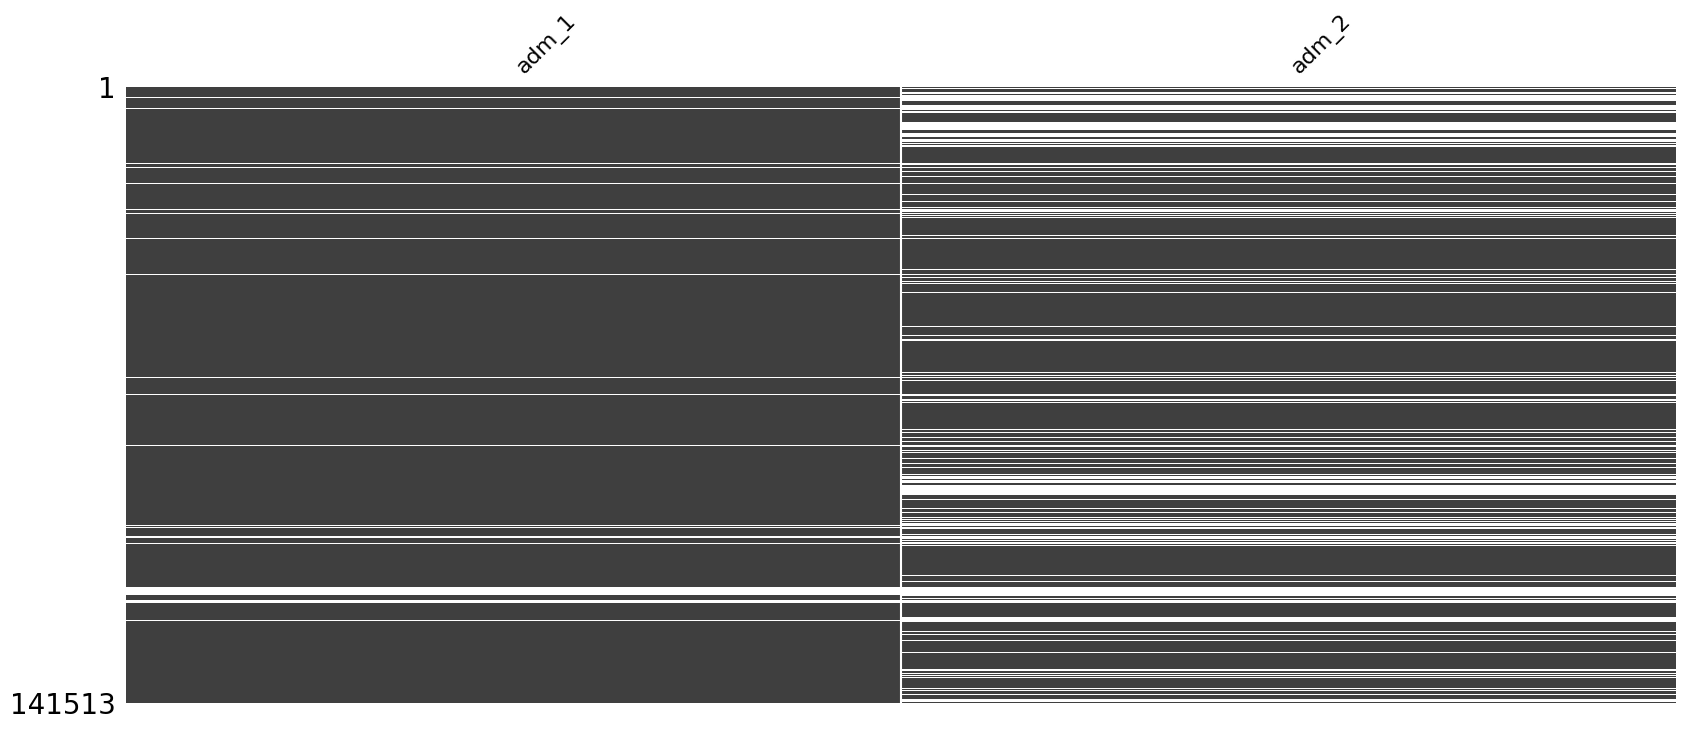

In [120]:
# Matriz de valores faltantes
msno.matrix(df_cace[['adm_1', 'adm_2']], figsize=(20,8), sparkline=False)

Se utilizan las variables 'where_prec' del dataset original para analizar como influye en la ausencia de datos en 'adm_1' y 'adm_2'.

Para recordar:
| Columna             | Descripción                                                          |
| ------------------- | -------------------------------------------------------------------- |
| `where_prec` | Indica la precisión de la ubicación del evento:<br>1 = Precisión exacta<br>2 = Radio de 25 km<br>3 = Municipio/distrito<br>4 = Provincia/estado<br>5 = Sin límites claros<br>6 = Solo país<br>7 = Agua/espacio |

In [136]:
# Filtrar las filas donde adm_1 o adm_2 son nulos
df_nulos_adm = df[df['adm_1'].isna() | df['adm_2'].isna()][['adm_1', 'adm_2', 'where_prec', 'event_clarity']]

df_nulos_adm.head()

,adm_1,adm_2,where_prec,event_clarity
0,Am?nat al ‘??imah governorate,NaN,1,1
1,‘Adan governorate,NaN,2,1
2,Abyan governorate,NaN,4,1
3,Abyan governorate,NaN,4,1
5,Abyan governorate,NaN,4,1


Los valores nulos de las variables 'adm_1' y 'adm_2' se distribuyen en todo el dataset, por lo tanto se considera que la ausencias de datos es complementamente aleatoria, son del tipo 'Missing Completely at Random (MCAR).

Analizar los datos con:
- Missing Completely at Random (MCAR): significa que la razón por la cuál el 
dato no está es completamente aleatoria, y que probablemente no podamos 
predecir el valor a partir de otro valor en los datos.
- Missing at Random (MAR): los datos faltantes pueden ser explicados por 
valores en las otras columnas, pero no por valores de esa columna. Por 
ejemplo, si cada columna representa una elección excluyente.
- Missing not at Random (MNAR): significa que es probable que la falta de ese 
dato no sea al azar. En este caso tenemos que investigar la causa por la que 
falta ese valor.


#### c. Normalizacion y estandarización

In [102]:
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'sklearn'